In [1]:
import tarfile
import urllib.request
import numpy as np
from matplotlib import pyplot as plt
plt.set_cmap("gray") # Otherwise grayscale images look purple
%matplotlib inline

In [2]:
url = 'http://udon.stacken.kth.se/~ninjin/comp0090_assignment_1_data.tar.gz'
ftpstream = urllib.request.urlopen(url)
tar = tarfile.open(fileobj=ftpstream, mode="r|gz")
tar.extractall()
tar.close

<bound method TarFile.close of <tarfile.TarFile object at 0x0000025DDCC924A8>>

In [3]:
trainxs = np.load("comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0))
trainys = np.load("comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0))
devys   = np.load("comp0090_assignment_1_data/fashion-dev-labels.npz")
testxs  = np.load("comp0090_assignment_1_data/fashion-test-imgs.npz").transpose((2, 1, 0))
testys  = np.load("comp0090_assignment_1_data/fashion-test-labels.npz")

In [4]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)
print(testxs.shape)
print(testys.shape)

(12000, 28, 28)
(12000,)
(1000, 28, 28)
(1000,)
(1000, 28, 28)
(1000,)


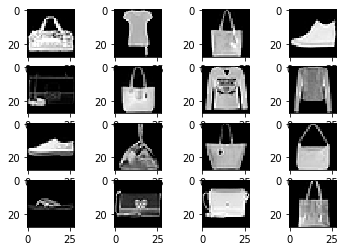

In [5]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(trainxs[np.random.randint(0, len(trainxs))])

In [6]:
trainxs = trainxs.reshape(-1, 784)
devxs = devxs.reshape(-1, 784)
testxs = testxs.reshape(-1, 784)

In [23]:
def _logistic_func(x):
    return 1/(1 + np.exp(-x))

def logistic_der(x):
    return _logistic_func(x) * (1 - _logistic_func(x))

In [33]:
class LogisticRegression:
    def __init__(self, d):
        self.w = np.zeros(d)
        self.b = 0
        
    def f(self, x):
        return _logistic_func(np.dot(self.w, x) + self.b)
    
    def p(self, x):
        if self.f(x) >= 0.5:
            return 1
        else:
            return 0

In [37]:
#Measure Accuracy

def accuracy(w, xs, ys):
    correct = 0
    for i in range(len(xs)):
        if f(w, xs[i]) == ys[i]:
            correct += 1
    return correct/len(xs)*100    